In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import seaborn as sns
from scipy.ndimage import gaussian_filter

def van_rossum_distance(u, v, dt = 0.1, epsilon = 1e-6):
    """Efficient calculation of the van Rossum distance between two spike trains u and v."""


    u = np.asarray(u)
    v = np.asarray(v)
    u = u-u[0]
    if len(v) > 0:
        v = v-v[0]

    isi_u = np.diff(u)
    tau = max(isi_u) + min(isi_u)
    tau = tau / 2

    # since tau is constant, we compute the kernel only once
    def kernel(t):
        return np.exp(-t / tau) / tau
    
    max_T = - tau * np.log(epsilon*tau) # time such that kernel(t) < epsilon
    t_kernel = np.arange(0, max_T + dt, dt)
    kernel_values = kernel(t_kernel)

    # u and v aligned with dt
    u_idx = np.round(u/dt).astype(int)
    v_idx = np.round(v/dt).astype(int)

    u_max = u_idx.max()
    if len(v_idx) > 0:
        v_max = v_idx.max()
    else:
        v_max = -1
    w = np.zeros(int(np.ceil(max(v_max, u_max) / dt) + 1))

    # at each spike time, we add the kernel to the window
    for i in u_idx:
        w[i:i+len(kernel_values)] += kernel_values
    for i in v_idx:
        w[i:i+len(kernel_values)] -= kernel_values
    
    w = w**2
    d = sum(w) * dt
    return d


def compute_van_rossum_distance(group):
    # Extract the first row as x
    x = group.iloc[0]
    # Extract the rest of the rows as y
    y = group.iloc[1:]
    # Compute the van Rossum distance
    for i in range(len(y)):
        y.iloc[i] = van_rossum_distance(x, y.iloc[i])
    # Compute the mean van Rossum distance
    mean_distance = y.mean()
    return mean_distance

In [2]:
cherry_picked_path = 'tmp/cherry_picked.csv'
not_cherry_picked_path = 'tmp/not_cherry_picked.csv'
predictions_path = 'tmp/predictions_stg.csv'
result_path = 'tmp/result.csv'

from inference import SpikeFeatureExtractor
sfe = SpikeFeatureExtractor()
if True:
    cherry_picked_df = pd.read_csv(cherry_picked_path, usecols=['g_s', 'g_u', 'spiking_times', 'ID'])
    cherry_picked_df['spiking_times'] = sfe.extract_from_dataframe(cherry_picked_df, verbose=True, num_workers=19)['spiking_times']
    cherry_picked_df['denominator'] = 0
    cherry_picked_df['numerator'] = 0

    # We compute the denominator

    not_cherry_picked_df = pd.read_csv(not_cherry_picked_path, usecols=['g_s', 'g_u', 'spiking_times', 'ID'])
    not_cherry_picked_df['spiking_times'] = sfe.extract_from_dataframe(not_cherry_picked_df, verbose=True, num_workers=19)['spiking_times']

    def compute_chunk(df, cherry_picked_chunk, position=0, value_name='denominator'):
        results = []

        i = 0
        for _, row in cherry_picked_chunk.iterrows():
            current_id = row['ID']
            group = pd.concat([row.to_frame().T, df[df['ID'] == current_id]])

            v = compute_van_rossum_distance(group['spiking_times'])

            # we add the ID and the value to the results
            results.append({'ID': current_id, value_name: v})

            i += 1
            if i % 50 == 0:
                print(f"Chunk {position} - {i}/{len(cherry_picked_chunk)}")

        return results

    def compute_values(df, cherry_picked_df, value_name='denominator',randomize=False):
        """
        return a df with two columns: 
        - ID 
        - values
        """
        df = df.dropna()

        if randomize:
            # TO GET A BASELINE, WE RANDOMIZE THE ID
            df['ID'] = np.random.permutation(df['ID'].values)
            # We randomize, but instances that were initially in the same group stay in the same group
            # Get unique group IDs
            #original_ids = df['ID'].unique()
            #shuffled_ids = np.random.permutation(original_ids)

            # Create a mapping from original ID to shuffled ID
            #id_mapping = dict(zip(original_ids, shuffled_ids))

            # Apply mapping to the DataFrame
            #df['ID'] = df['ID'].map(id_mapping)


        # we use multiprocessing to speed up the computation; 
        num_cpu = 20
        # we split in num_cpu chunks
        df_split = np.array_split(cherry_picked_df, num_cpu)
        
        print(f"Computing {value_name} for {len(df_split)} chunks of mean {len(df_split[0])} rows")

        with Pool(num_cpu) as pool:
            results = pool.starmap(compute_chunk, [(df, chunk, i, value_name) for i, chunk in enumerate(df_split)])

        # Flatten results and convert to DataFrame
        flat_results = [item for sublist in results for item in sublist]
        return pd.DataFrame(flat_results, columns=['ID', value_name])

    denominator_values = compute_values(not_cherry_picked_df, cherry_picked_df, value_name='denominator')
    # we fill the denominator column of the cherry picked df based on the ID
    cherry_picked_df = cherry_picked_df.merge(denominator_values, on='ID', how='left')

    # before computing the numerator, we make some space by del
    del not_cherry_picked_df

    predictions_df = pd.read_csv(predictions_path, usecols=['g_s', 'g_u', 'spiking_times', 'ID'])
    predictions_df['spiking_times'] = sfe.extract_from_dataframe(predictions_df, verbose=True, num_workers=19)['spiking_times']
    # We compute the numerator
    numerator_values = compute_values(predictions_df, cherry_picked_df, value_name='numerator', randomize=False)
    # we fill the numerator column of the cherry picked df based on the ID
    cherry_picked_df = cherry_picked_df.merge(numerator_values, on='ID', how='left')

    del predictions_df

    # SAVE
    # we drop the spiking times column
    cherry_picked_df = cherry_picked_df.drop(columns=['spiking_times'])
    cherry_picked_df.to_csv(result_path, index=False)

Preprocessing data
Data preprocessed, extracting features
Extracting features from 12000 samples using 19 workers


100%|██████████| 19/19 [00:00<00:00, 32.58it/s]


Preprocessing data
Data preprocessed, extracting features
Extracting features from 179456 samples using 19 workers


100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


Computing denominator for 20 chunks of mean 600 rows


/home/julienbrandoit/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Chunk 0 - 50/600
Chunk 1 - 50/600
Chunk 4 - 50/600
Chunk 5 - 50/600
Chunk 2 - 50/600
Chunk 6 - 50/600
Chunk 3 - 50/600
Chunk 7 - 50/600
Chunk 10 - 50/600
Chunk 9 - 50/600
Chunk 8 - 50/600
Chunk 12 - 50/600
Chunk 1 - 100/600
Chunk 11 - 50/600
Chunk 13 - 50/600
Chunk 0 - 100/600
Chunk 14 - 50/600
Chunk 4 - 100/600
Chunk 5 - 100/600
Chunk 15 - 50/600
Chunk 2 - 100/600
Chunk 6 - 100/600
Chunk 16 - 50/600
Chunk 3 - 100/600
Chunk 17 - 50/600
Chunk 18 - 50/600
Chunk 19 - 50/600
Chunk 10 - 100/600
Chunk 7 - 100/600
Chunk 9 - 100/600
Chunk 8 - 100/600
Chunk 12 - 100/600
Chunk 11 - 100/600
Chunk 1 - 150/600
Chunk 13 - 100/600
Chunk 0 - 150/600
Chunk 14 - 100/600
Chunk 4 - 150/600
Chunk 5 - 150/600
Chunk 15 - 100/600
Chunk 2 - 150/600Chunk 6 - 150/600

Chunk 16 - 100/600
Chunk 17 - 100/600
Chunk 3 - 150/600
Chunk 18 - 100/600
Chunk 19 - 100/600
Chunk 10 - 150/600
Chunk 7 - 150/600
Chunk 9 - 150/600
Chunk 8 - 150/600
Chunk 12 - 150/600
Chunk 13 - 150/600
Chunk 11 - 150/600
Chunk 1 - 200/600
Chunk 

100%|██████████| 19/19 [00:03<00:00,  5.17it/s]


Computing numerator for 20 chunks of mean 600 rows


/home/julienbrandoit/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Chunk 1 - 50/600
Chunk 2 - 50/600
Chunk 3 - 50/600
Chunk 0 - 50/600
Chunk 4 - 50/600
Chunk 6 - 50/600
Chunk 5 - 50/600
Chunk 7 - 50/600
Chunk 8 - 50/600
Chunk 10 - 50/600
Chunk 9 - 50/600
Chunk 11 - 50/600
Chunk 12 - 50/600
Chunk 1 - 100/600
Chunk 13 - 50/600
Chunk 14 - 50/600
Chunk 0 - 100/600
Chunk 2 - 100/600
Chunk 3 - 100/600
Chunk 4 - 100/600
Chunk 15 - 50/600
Chunk 16 - 50/600
Chunk 17 - 50/600
Chunk 6 - 100/600
Chunk 18 - 50/600
Chunk 5 - 100/600
Chunk 7 - 100/600
Chunk 19 - 50/600
Chunk 8 - 100/600
Chunk 10 - 100/600
Chunk 9 - 100/600
Chunk 11 - 100/600
Chunk 12 - 100/600
Chunk 1 - 150/600
Chunk 13 - 100/600
Chunk 14 - 100/600
Chunk 2 - 150/600
Chunk 0 - 150/600
Chunk 3 - 150/600
Chunk 15 - 100/600
Chunk 4 - 150/600
Chunk 16 - 100/600
Chunk 17 - 100/600
Chunk 18 - 100/600
Chunk 6 - 150/600
Chunk 5 - 150/600
Chunk 19 - 100/600
Chunk 7 - 150/600
Chunk 8 - 150/600
Chunk 10 - 150/600
Chunk 9 - 150/600
Chunk 11 - 150/600
Chunk 12 - 150/600
Chunk 14 - 150/600
Chunk 1 - 200/600
Chunk 

In [3]:
# Step 1: Read the result DataFrame
result_path = 'tmp/result_tau_midrange.csv'
result_df = pd.read_csv(result_path)

# Compute the ratio of numerator_y and denominator_y
result_df['ratio'] = result_df['numerator_y'] / result_df['denominator_y']
#result_df['ratio'] = np.log(result_df['ratio'])


/tmp/ipykernel_13810/3417542303.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['ratio'].median().reset_index()


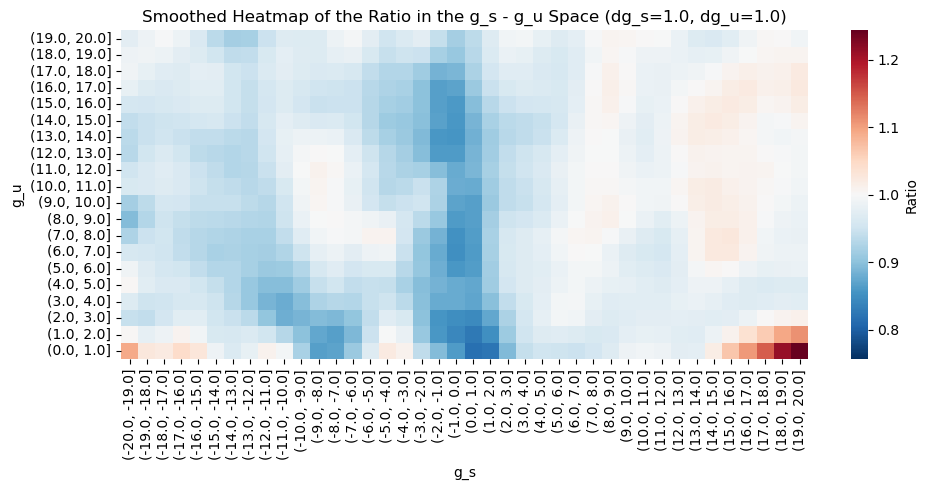

In [4]:

# Set the bin size
dg = 1.0
dg_s = dg       # Bin size for g_s
dg_u = dg   # Bin size for g_u

# Step 2: Define the bin edges for g_s and g_u using dg
g_s_bins = np.arange(-20, 20 + dg_s, dg_s)  # Bin edges for g_s
g_u_bins = np.arange(0, 20 + dg_u, dg_u)    # Bin edges for g_u

# Bin the data for g_s and g_u
result_df['g_s_bin'] = pd.cut(result_df['g_s'], bins=g_s_bins)
result_df['g_u_bin'] = pd.cut(result_df['g_u'], bins=g_u_bins)

# Step 3: Group by the binned values and compute the median ratio in each bin
heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['ratio'].median().reset_index()

# Step 4: Pivot the data into a 2D array format for heatmap plotting
heatmap_data_pivot = heatmap_data.pivot(index='g_u_bin', columns='g_s_bin', values='ratio')

# Convert pivot table to numpy array and apply Gaussian smoothing
heatmap_array = heatmap_data_pivot.to_numpy()
nan_mask = np.isnan(heatmap_array)
heatmap_array_filled = np.where(nan_mask, 0, heatmap_array)  # Fill NaNs for smoothing


# Step 4: Fill missing values with average of neighbors
def fill_nans_with_neighbor_mean(arr):
    filled = arr.copy()
    nan_indices = np.argwhere(np.isnan(filled))
    for i, j in nan_indices:
        neighbors = []
        for x in [i-1, i, i+1]:
            for y in [j-1, j, j+1]:
                if (0 <= x < arr.shape[0]) and (0 <= y < arr.shape[1]) and not np.isnan(arr[x, y]) and (x != i or y != j):
                    neighbors.append(arr[x, y])
        if neighbors:
            filled[i, j] = np.mean(neighbors)
    return filled

heatmap_array_filled = fill_nans_with_neighbor_mean(heatmap_array)

# Apply Gaussian filter
smoothed_array = gaussian_filter(heatmap_array_filled, sigma=dg)

# Restore NaNs after smoothing
smoothed_array[nan_mask] = np.nan

# Step 5: Plot the smoothed heatmap
plt.figure(figsize=(10, 5))

# Compute symmetric colorbar range
max_abs = np.nanmax(np.abs(smoothed_array))

max_dev = np.nanmax(np.abs(smoothed_array - 1))
vmin = 1 - max_dev
vmax = 1 + max_dev

sns.heatmap(smoothed_array,
            cmap='RdBu_r',
            annot=False,
            fmt=".2f",
            vmax=vmax,
            vmin=vmin,
            cbar_kws={'label': 'Ratio'},
            xticklabels=heatmap_data_pivot.columns.astype(str),
            yticklabels=heatmap_data_pivot.index.astype(str))

plt.gca().invert_yaxis()
plt.title(f"Smoothed Heatmap of the Ratio in the g_s - g_u Space (dg_s={dg_s}, dg_u={dg_u})")
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.tight_layout()
plt.savefig('figures/heatmap_stg.svg', dpi=300)
plt.show()

/tmp/ipykernel_13810/948757254.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['numerator_y'].median().reset_index()


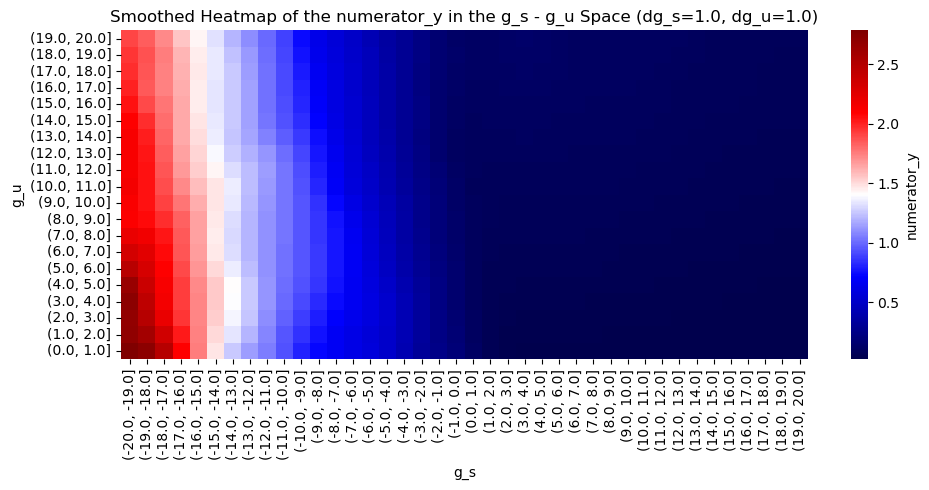

In [5]:

# Set the bin size
dg = 1.0
dg_s = dg       # Bin size for g_s
dg_u = dg   # Bin size for g_u

# Step 2: Define the bin edges for g_s and g_u using dg
g_s_bins = np.arange(-20, 20 + dg_s, dg_s)  # Bin edges for g_s
g_u_bins = np.arange(0, 20 + dg_u, dg_u)    # Bin edges for g_u

# Bin the data for g_s and g_u
result_df['g_s_bin'] = pd.cut(result_df['g_s'], bins=g_s_bins)
result_df['g_u_bin'] = pd.cut(result_df['g_u'], bins=g_u_bins)

# Step 3: Group by the binned values and compute the median ratio in each bin
heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['numerator_y'].median().reset_index()

# Step 4: Pivot the data into a 2D array format for heatmap plotting
heatmap_data_pivot = heatmap_data.pivot(index='g_u_bin', columns='g_s_bin', values='numerator_y')

# Convert pivot table to numpy array and apply Gaussian smoothing
heatmap_array = heatmap_data_pivot.to_numpy()
nan_mask = np.isnan(heatmap_array)
heatmap_array_filled = np.where(nan_mask, 0, heatmap_array)  # Fill NaNs for smoothing


# Step 4: Fill missing values with average of neighbors
def fill_nans_with_neighbor_mean(arr):
    filled = arr.copy()
    nan_indices = np.argwhere(np.isnan(filled))
    for i, j in nan_indices:
        neighbors = []
        for x in [i-1, i, i+1]:
            for y in [j-1, j, j+1]:
                if (0 <= x < arr.shape[0]) and (0 <= y < arr.shape[1]) and not np.isnan(arr[x, y]) and (x != i or y != j):
                    neighbors.append(arr[x, y])
        if neighbors:
            filled[i, j] = np.mean(neighbors)
    return filled

heatmap_array_filled = fill_nans_with_neighbor_mean(heatmap_array)

# Apply Gaussian filtera
smoothed_array = gaussian_filter(heatmap_array_filled, sigma=dg)

# Step 5: Plot the smoothed heatmap
plt.figure(figsize=(10, 5))

sns.heatmap(smoothed_array,
            cmap='seismic',
            annot=False,
            fmt=".2f",
            cbar_kws={'label': 'numerator_y'},
            xticklabels=heatmap_data_pivot.columns.astype(str),
            yticklabels=heatmap_data_pivot.index.astype(str))

plt.gca().invert_yaxis()
plt.title(f"Smoothed Heatmap of the numerator_y in the g_s - g_u Space (dg_s={dg_s}, dg_u={dg_u})")
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13810/2146359231.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['denominator_y'].median().reset_index()


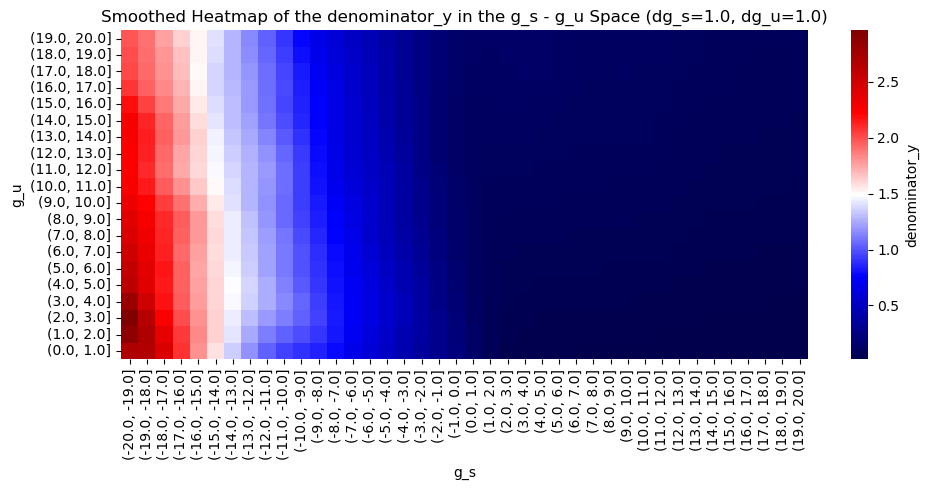

In [6]:

# Set the bin size
dg = 1.0
dg_s = dg       # Bin size for g_s
dg_u = dg   # Bin size for g_u

# Step 2: Define the bin edges for g_s and g_u using dg
g_s_bins = np.arange(-20, 20 + dg_s, dg_s)  # Bin edges for g_s
g_u_bins = np.arange(0, 20 + dg_u, dg_u)    # Bin edges for g_u

# Bin the data for g_s and g_u
result_df['g_s_bin'] = pd.cut(result_df['g_s'], bins=g_s_bins)
result_df['g_u_bin'] = pd.cut(result_df['g_u'], bins=g_u_bins)

# Step 3: Group by the binned values and compute the median ratio in each bin
heatmap_data = result_df.groupby(['g_s_bin', 'g_u_bin'])['denominator_y'].median().reset_index()

# Step 4: Pivot the data into a 2D array format for heatmap plotting
heatmap_data_pivot = heatmap_data.pivot(index='g_u_bin', columns='g_s_bin', values='denominator_y')

# Convert pivot table to numpy array and apply Gaussian smoothing
heatmap_array = heatmap_data_pivot.to_numpy()
nan_mask = np.isnan(heatmap_array)
heatmap_array_filled = np.where(nan_mask, 0, heatmap_array)  # Fill NaNs for smoothing


# Step 4: Fill missing values with average of neighbors
def fill_nans_with_neighbor_mean(arr):
    filled = arr.copy()
    nan_indices = np.argwhere(np.isnan(filled))
    for i, j in nan_indices:
        neighbors = []
        for x in [i-1, i, i+1]:
            for y in [j-1, j, j+1]:
                if (0 <= x < arr.shape[0]) and (0 <= y < arr.shape[1]) and not np.isnan(arr[x, y]) and (x != i or y != j):
                    neighbors.append(arr[x, y])
        if neighbors:
            filled[i, j] = np.mean(neighbors)
    return filled

heatmap_array_filled = fill_nans_with_neighbor_mean(heatmap_array)

# Apply Gaussian filtera
smoothed_array = gaussian_filter(heatmap_array_filled, sigma=dg)

# Step 5: Plot the smoothed heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(smoothed_array,
            cmap='seismic',
            annot=False,
            fmt=".2f",
            cbar_kws={'label': 'denominator_y'},
            xticklabels=heatmap_data_pivot.columns.astype(str),
            yticklabels=heatmap_data_pivot.index.astype(str))

plt.gca().invert_yaxis()
plt.title(f"Smoothed Heatmap of the denominator_y in the g_s - g_u Space (dg_s={dg_s}, dg_u={dg_u})")
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13810/2876773569.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_id_random = result_id_random.groupby(['g_s_bin', 'g_u_bin'])['ratio'].median().reset_index()


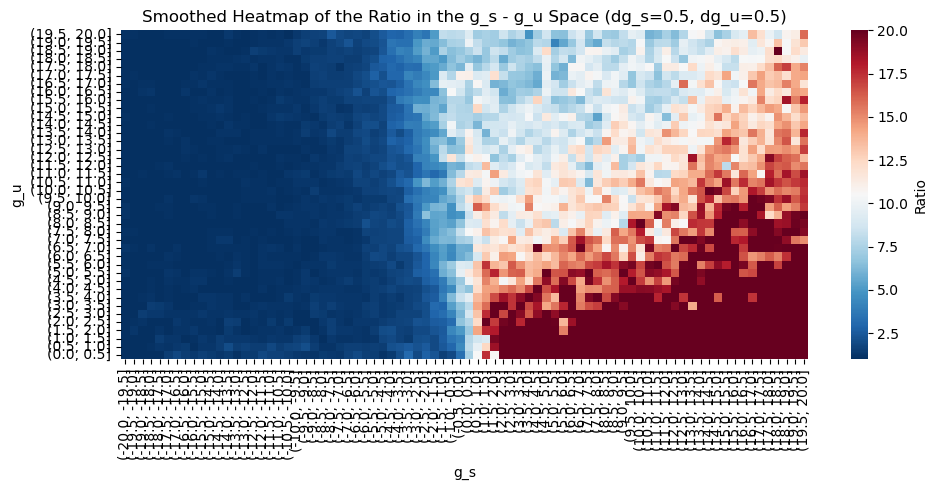

In [7]:
result_id_random = pd.read_csv('tmp/result_random.csv')
result_id_random['ratio'] = result_id_random['numerator_y'] / result_id_random['denominator_y']
#result_id_random['ratio'] = np.log(result_id_random['ratio'])

# Set the bin size
dg = 0.5
dg_s = dg       # Bin size for g_s
dg_u = dg   # Bin size for g_u
# Step 2: Define the bin edges for g_s and g_u using dg
g_s_bins = np.arange(-20, 20 + dg_s, dg_s)  # Bin edges for g_s
g_u_bins = np.arange(0, 20 + dg_u, dg_u)    # Bin edges for g_u
# Bin the data for g_s and g_u

result_id_random['g_s_bin'] = pd.cut(result_id_random['g_s'], bins=g_s_bins)
result_id_random['g_u_bin'] = pd.cut(result_id_random['g_u'], bins=g_u_bins)
# Step 3: Group by the binned values and compute the median ratio in each bin
heatmap_data_id_random = result_id_random.groupby(['g_s_bin', 'g_u_bin'])['ratio'].median().reset_index()
# Step 4: Pivot the data into a 2D array format for heatmap plotting
heatmap_data_id_random_pivot = heatmap_data_id_random.pivot(index='g_u_bin', columns='g_s_bin', values='ratio')
# Convert pivot table to numpy array and apply Gaussian smoothing
heatmap_array_id_random = heatmap_data_id_random_pivot.to_numpy()
nan_mask_id_random = np.isnan(heatmap_array_id_random)
heatmap_array_id_random_filled = np.where(nan_mask_id_random, 0, heatmap_array_id_random)  # Fill NaNs for smoothing
# Step 4: Fill missing values with average of neighbors
def fill_nans_with_neighbor_mean(arr):
    filled = arr.copy()
    nan_indices = np.argwhere(np.isnan(filled))
    for i, j in nan_indices:
        neighbors = []
        for x in [i-1, i, i+1]:
            for y in [j-1, j, j+1]:
                if (0 <= x < arr.shape[0]) and (0 <= y < arr.shape[1]) and not np.isnan(arr[x, y]) and (x != i or y != j):
                    neighbors.append(arr[x, y])
        if neighbors:
            filled[i, j] = np.mean(neighbors)
    return filled
heatmap_array_id_random_filled = fill_nans_with_neighbor_mean(heatmap_array_id_random)
# Apply Gaussian filtera
smoothed_array_id_random = gaussian_filter(heatmap_array_id_random_filled, sigma=dg)
# compute the ratio of the two smoothed arrays
smoothed_array_ratio = smoothed_array_id_random
# Step 5: Plot the smoothed heatmap
plt.figure(figsize=(10, 5))
# Compute symmetric colorbar range
max_abs = np.nanmax(np.abs(smoothed_array_ratio))
max_dev = np.nanmax(np.abs(smoothed_array_ratio - 1))
vmin = 1
vmax = 20
sns.heatmap(smoothed_array_ratio,
            cmap='RdBu_r',
            annot=False,
            fmt=".2f",
            vmax=vmax,
            vmin=vmin,
            cbar_kws={'label': 'Ratio'},
            xticklabels=heatmap_data_id_random_pivot.columns.astype(str),
            yticklabels=heatmap_data_id_random_pivot.index.astype(str))
plt.gca().invert_yaxis()
plt.title(f"Smoothed Heatmap of the Ratio in the g_s - g_u Space (dg_s={dg_s}, dg_u={dg_u})")
plt.xlabel('g_s')
plt.ylabel('g_u')
plt.tight_layout()
plt.show()
